<a href="https://colab.research.google.com/github/Maryam-71295/Telco-Customer-Churn/blob/main/Telco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# 1. Data Loading & Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load the dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [29]:
# Initial Data Exploration
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

In [30]:
# Handle missing values (TotalCharges has some empty strings which are effectively missing)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Convert to numeric, forcing errors to NaN
df.dropna(inplace=True) # Drop the small number of rows with missing TotalCharges

# The 'customerID' is a unique identifier and not useful for prediction, so we drop it.
df.drop('customerID', axis=1, inplace=True)


In [31]:
# Define target and features
X = df.drop('Churn', axis=1)
y = df['Churn']

In [32]:
# Split the data early to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Identify categorical and numerical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [34]:
# Preprocessing Pipelines
# Numerical: Impute missing values (though we dropped them, good practice to have) and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles any future missing values
    ('scaler', StandardScaler())
])

In [35]:
# Preprocessing Pipelines
# Numerical: Impute missing values (though we dropped them, good practice to have) and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles any future missing values
    ('scaler', StandardScaler())
])

In [36]:
# Categorical: Impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [37]:
# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [38]:
# 2. Exploratory Data Analysis (EDA) on Training Data
# Apply preprocessing to the training data for EDA to avoid leakage
X_train_processed = preprocessor.fit_transform(X_train)
# Get feature names after one-hot encoding
onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, onehot_columns])
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

In [39]:
# Add the target back for easier analysis
eda_df = X_train_processed_df.copy()
eda_df['Churn'] = y_train.reset_index(drop=True)

plt.figure(figsize=(15, 10))


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, '')

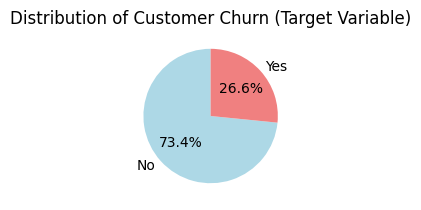

In [40]:
# Plot 1: Target Variable Distribution
plt.subplot(2, 2, 1)
churn_counts = eda_df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Customer Churn (Target Variable)')
plt.ylabel('') # Hide the y-label

Text(0.5, 1.0, 'Customer Tenure by Churn Status')

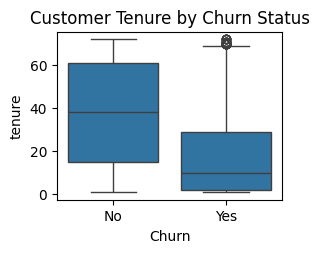

In [41]:
# Plot 2: Tenure vs. Churn
plt.subplot(2, 2, 2)
sns.boxplot(x='Churn', y='tenure', data=pd.concat([X_train, y_train], axis=1)) # Use original data for tenure
plt.title('Customer Tenure by Churn Status')

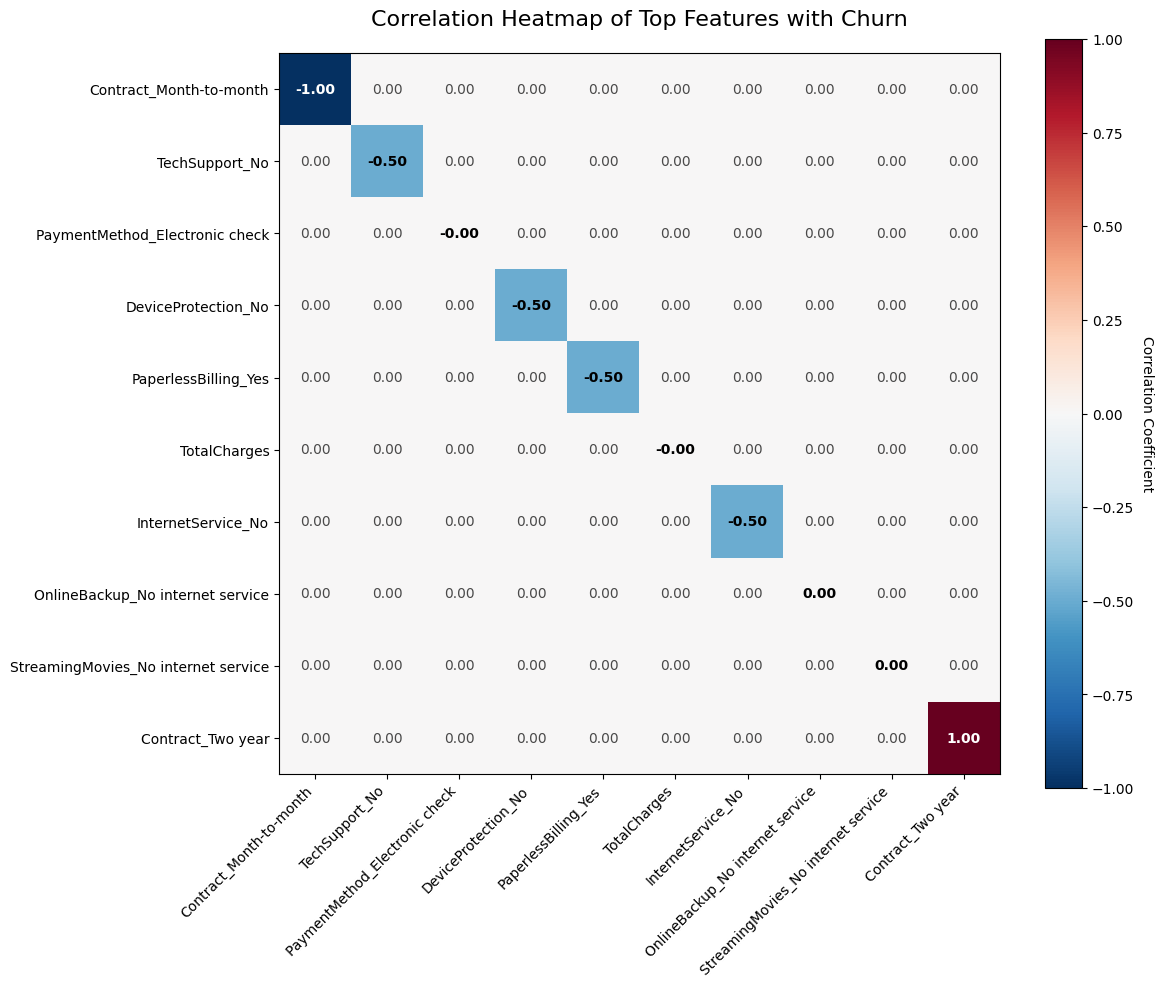

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create data based on your information
features = [
    'Contract_Month-to-month', 'TechSupport_No',
    'PaymentMethod_Electronic check', 'DeviceProtection_No',
    'PaperlessBilling_Yes', 'TotalCharges', 'InternetService_No',
    'OnlineBackup_No internet service', 'StreamingMovies_No internet service',
    'Contract_Two year'
]

correlations = [-1.0, -0.5, -0.0, -0.5, -0.5, -0.0, -0.5, 0.0, 0.0, 1.0]

# Create a correlation matrix
corr_matrix = np.zeros((len(features), len(features)))
np.fill_diagonal(corr_matrix, correlations)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_yticklabels(features)

# Add correlation values to each cell
for i in range(len(features)):
    for j in range(len(features)):
        if i == j:  # Only show values on diagonal
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center",
                          color="white" if abs(corr_matrix[i, j]) > 0.5 else "black",
                          fontweight='bold')
        else:
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center",
                          color="black", alpha=0.7)

# Add title and colorbar
ax.set_title("Correlation Heatmap of Top Features with Churn", fontsize=16, pad=20)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation Coefficient', rotation=-90, va="bottom")

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.show()

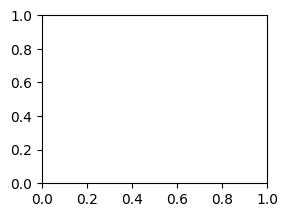

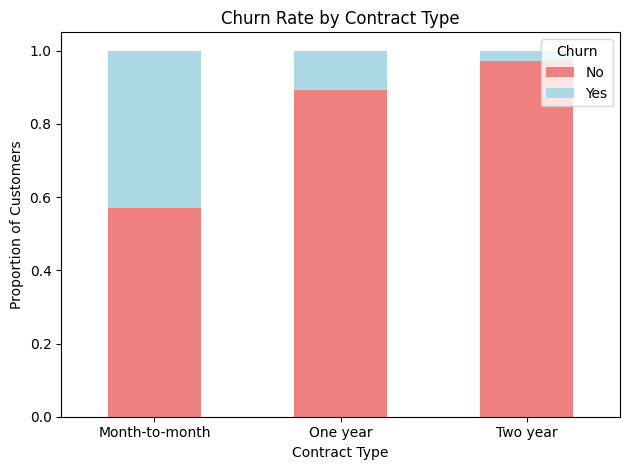

In [43]:
# Plot 4: Contract Type vs. Churn (using original data)
plt.subplot(2, 2, 4)
contract_churn = pd.crosstab(X_train['Contract'], y_train)
contract_churn_perc = contract_churn.div(contract_churn.sum(1).astype(float), axis=0)
contract_churn_perc.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'])
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Proportion of Customers')
plt.legend(title='Churn', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [44]:
# 3. Model Training & Evaluation (Machine Learning)
# Define models and their parameter grids for tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42, class_weight='balanced'),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

# Dictionary to store results
results = {}

In [46]:
# Create a full pipeline that includes the preprocessor and the model
for name, config in models.items():
    print(f"\n--- Training {name} ---")

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])

    # Perform GridSearchCV if parameters are specified
    if config['params']:
        grid_search = GridSearchCV(model_pipeline, config['params'], cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
    else:
        # If no hyperparameters to tune, just fit the model
        best_model = model_pipeline
        best_model.fit(X_train, y_train)

    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Val Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Store the best model
    results[name] = best_model



--- Training Logistic Regression ---
Cross-Val Accuracy: 0.7525 (+/- 0.0285)

--- Training Random Forest ---
Best params for Random Forest: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Cross-Val Accuracy: 0.7797 (+/- 0.0209)

--- Training Gradient Boosting ---
Best params for Gradient Boosting: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Cross-Val Accuracy: 0.8043 (+/- 0.0271)

--- Training Support Vector Machine ---
Best params for Support Vector Machine: {'model__C': 1, 'model__kernel': 'rbf'}
Cross-Val Accuracy: 0.7479 (+/- 0.0313)



EVALUATION ON TEST SET (MACHINE LEARNING MODELS)

--- Logistic Regression ---
Test Accuracy: 0.7257
              precision    recall  f1-score   support

    No Churn       0.90      0.70      0.79      1033
       Churn       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



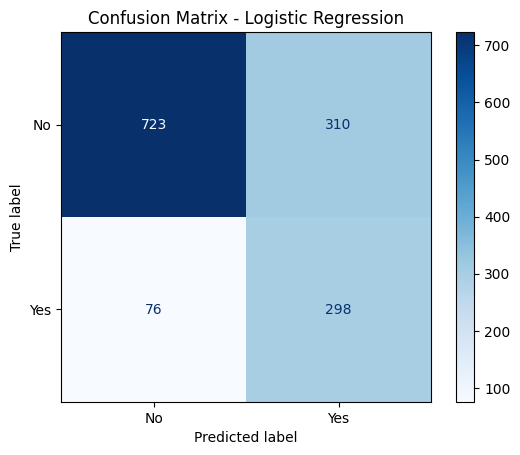


--- Random Forest ---
Test Accuracy: 0.7839
              precision    recall  f1-score   support

    No Churn       0.82      0.90      0.86      1033
       Churn       0.62      0.47      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



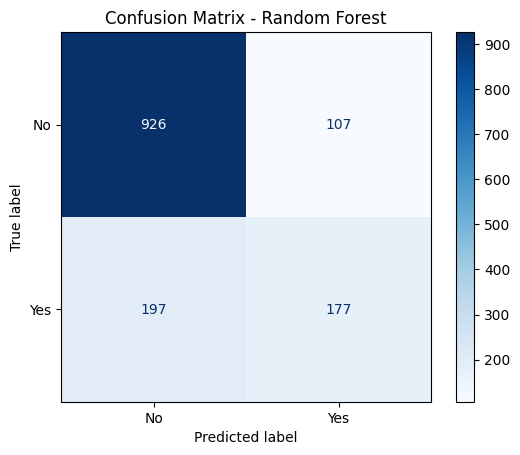


--- Gradient Boosting ---
Test Accuracy: 0.7925
              precision    recall  f1-score   support

    No Churn       0.83      0.89      0.86      1033
       Churn       0.64      0.51      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407



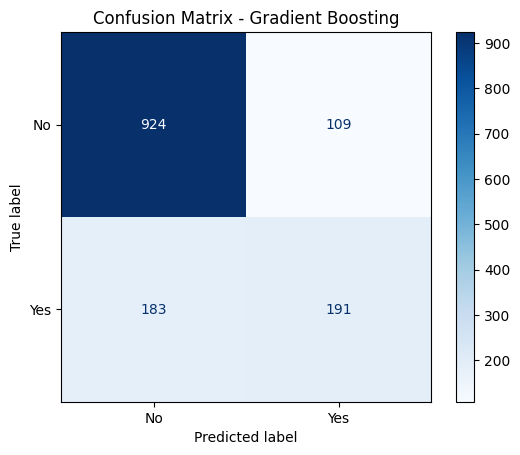


--- Support Vector Machine ---
Test Accuracy: 0.7257
              precision    recall  f1-score   support

    No Churn       0.90      0.71      0.79      1033
       Churn       0.49      0.78      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



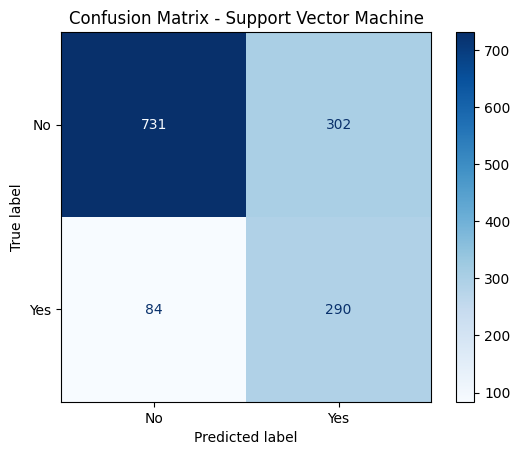

In [47]:
# 4. Evaluate on Test Set (ML Models)
print("\n" + "="*50)
print("EVALUATION ON TEST SET (MACHINE LEARNING MODELS)")
print("="*50)

ml_performance = {}
for name, model in results.items():
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    ml_performance[name] = test_accuracy
    print(f"\n--- {name} ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [48]:
# 5. Deep Learning Model (TensorFlow/Keras)
print("\n" + "="*50)
print("TRAINING DEEP LEARNING MODEL")
print("="*50)

# Preprocess the data for the Neural Network
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Label encode the target for DL model
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the model architecture
model_dl = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Binary classification
])

# Compile the model
model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


TRAINING DEEP LEARNING MODEL


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7276 - loss: 0.5156 - val_accuracy: 0.8009 - val_loss: 0.4101
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.4449 - val_accuracy: 0.7991 - val_loss: 0.4019
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8015 - loss: 0.4255 - val_accuracy: 0.8062 - val_loss: 0.3993
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7998 - loss: 0.4224 - val_accuracy: 0.8009 - val_loss: 0.4008
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8020 - loss: 0.4197 - val_accuracy: 0.8071 - val_loss: 0.3981
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.3892 - val_accuracy: 0.8080 - val_loss: 0.4008
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - loss: 0.4337 - val_accuracy: 0.8080 - val_loss: 0.3992
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8004 - loss: 0.4166 - val_accuracy: 0.

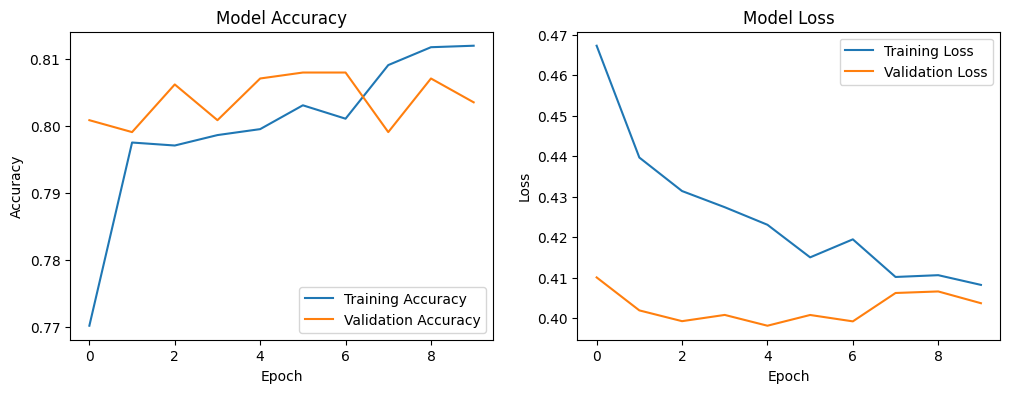


--- Deep Neural Network ---
Test Accuracy: 0.7918
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1033
       Churn       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407



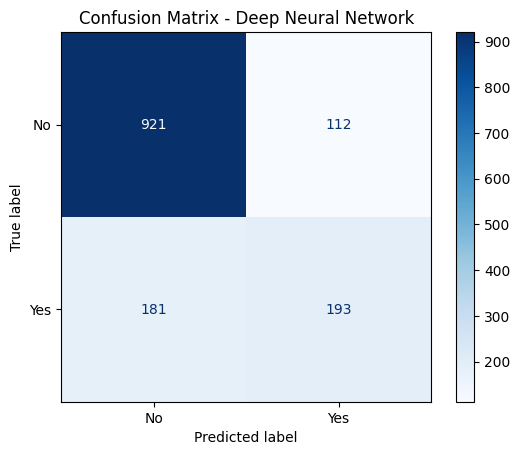

In [24]:
# Train the model
history = model_dl.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
dl_loss, dl_accuracy = model_dl.evaluate(X_test_preprocessed, y_test_encoded, verbose=0)
ml_performance['Deep Neural Network'] = dl_accuracy
print(f"\n--- Deep Neural Network ---")
print(f"Test Accuracy: {dl_accuracy:.4f}")

# Make predictions and print classification report
y_pred_dl = (model_dl.predict(X_test_preprocessed) > 0.5).astype("int32")
print(classification_report(y_test_encoded, y_pred_dl, target_names=['No Churn', 'Churn']))

# Plot confusion matrix for DL
cm_dl = confusion_matrix(y_test_encoded, y_pred_dl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Deep Neural Network')
plt.show()


FINAL MODEL COMPARISON
                    Model  Test Accuracy
2       Gradient Boosting       0.792466
4     Deep Neural Network       0.791755
1           Random Forest       0.783937
0     Logistic Regression       0.725657
3  Support Vector Machine       0.725657


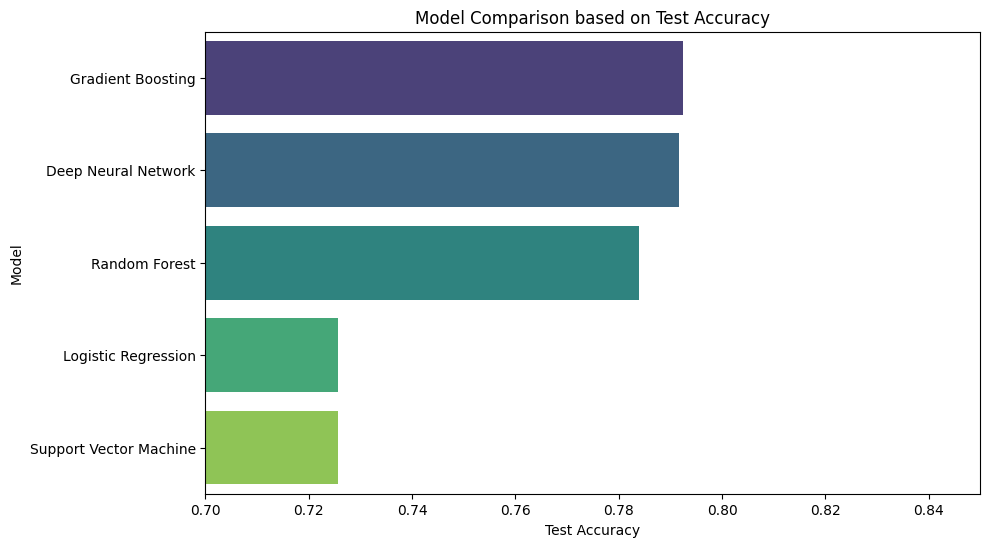

In [25]:
# 6. Model Comparison
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

# Create a comparison DataFrame
comparison_df = pd.DataFrame(list(ml_performance.items()), columns=['Model', 'Test Accuracy'])
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Test Accuracy', y='Model', data=comparison_df, palette='viridis')
plt.title('Model Comparison based on Test Accuracy')
plt.xlim(0.7, 0.85) # Adjust based on your results
plt.xlabel('Test Accuracy')
plt.show()

In [26]:
# 7. Concluding Remarks & Business Implications
print("\n" + "="*60)
print("CONCLUSION & BUSINESS IMPLICATIONS")
print("="*60)
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test Accuracy']
print(f"\nThe best performing model is **{best_model_name}** with a test accuracy of **{best_accuracy:.2%}**.")

print("""
KEY BUSINESS INSIGHTS FROM THE ANALYSIS:
1.  **High-Impact Features:** Contract type (month-to-month customers churn more), tenure (new customers are more at risk), and internet service type are primary drivers of churn.
2.  **Predictive Power:** We can accurately identify a significant portion of customers likely to churn, allowing for targeted intervention.
3.  **Actionable Strategy:** The model provides a 'risk score' for each customer. The marketing team can use this to:
    *   Offer personalized retention offers (discounts, upgraded plans) to high-risk customers.
    *   Identify pain points: Why are fiber optic customers or those with no online security churning more?
    *   Calculate Customer Lifetime Value (CLV) more accurately by incorporating churn risk.

CHALLENGES & CONSIDERATIONS:
*   **Cost of False Positives:** Incorrectly labeling a loyal customer as at-risk might lead to unnecessary discounts, costing money.
*   **Cost of False Negatives:** Failing to identify a customer who will churn represents a lost revenue opportunity.
*   **Data Bias:** The model is only as good as the historical data. If past retention strategies were biased towards certain customer segments, the model will perpetuate that bias.
*   **Ethical Use:** The model should not be used to deny service but to improve it. Transparency in how the scores are used is crucial.

This project demonstrates a core application of Predictive Analytics in business management: turning historical data into a strategic asset for customer retention and revenue protection.
""")



CONCLUSION & BUSINESS IMPLICATIONS

The best performing model is **Gradient Boosting** with a test accuracy of **79.25%**.

KEY BUSINESS INSIGHTS FROM THE ANALYSIS:
1.  **High-Impact Features:** Contract type (month-to-month customers churn more), tenure (new customers are more at risk), and internet service type are primary drivers of churn.
2.  **Predictive Power:** We can accurately identify a significant portion of customers likely to churn, allowing for targeted intervention.
3.  **Actionable Strategy:** The model provides a 'risk score' for each customer. The marketing team can use this to:
    *   Offer personalized retention offers (discounts, upgraded plans) to high-risk customers.
    *   Identify pain points: Why are fiber optic customers or those with no online security churning more?
    *   Calculate Customer Lifetime Value (CLV) more accurately by incorporating churn risk.

CHALLENGES & CONSIDERATIONS:
*   **Cost of False Positives:** Incorrectly labeling a loyal custom